# Detecting Frauds in E-commerce Transactions

[![LinkedIn](https://img.shields.io/badge/LinkedIn-igor--trevelin-blue)](https://www.linkedin.com/in/igor-trevelin/)
[![GitHub](https://img.shields.io/badge/GitHub-IgorTrevelin-purple)](https://github.com/IgorTrevelin)

<div style="display: block; text-align: center;">
    <img style="width: 600px" src="img/20945347.jpg" alt="Imagem de vectorjuice no Freepik"/>
    <p style="font-size: 11px; text-align:center;"><a href="https://br.freepik.com/vetores-gratis/cerebro-com-circuito-digital-e-programador-com-laptop-aprendizado-de-maquina-inteligencia-artificial-cerebro-digital-e-conceito-de-processo-de-pensamento-artificial-ilustracao-isolada-em-vetor_11668759.htm">Imagem de vectorjuice</a> no Freepik</p>
</div>

This project is based on a study case from [P.E.D by Renata Biaggi](https://www.renatabiaggi.com/ped), who provided the business problem/context and dataset.

Fraud detection in e-commerce is a critical component of ensuring the **security** and **trustworthiness** of online transactions. With the exponential growth of online shopping, fraudsters have become increasingly sophisticated in their attempts to exploit vulnerabilities in the system. E-commerce companies employ a variety of advanced techniques and technologies to identify and **prevent fraudulent activities**. By continuously evolving and adapting their fraud detection systems, e-commerce platforms not only **protect their customers from financial loss** but also maintain the integrity of their online marketplace.

Following this context, this project aims to extract insights about the most promising features that can be used to automatically detect frauds in e-commerce transactions and to build a machine learning fraud detection solution.

## Importing Required Libraries

In [1]:
# installing python dependencies
!pip install -r requirements.txt -q

In [2]:
# downlading spacy pt model for natural language processing
!python -m spacy download pt_core_news_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [121]:
import os
import math
import warnings
import time
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import spacy
nlp = spacy.load("pt_core_news_sm")

from wordcloud import WordCloud

from scipy.stats import mannwhitneyu, chi2_contingency

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn import set_config
set_config(transform_output='pandas')

import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostClassifier

from category_encoders import TargetEncoder

from feature_engine.encoding import RareLabelEncoder

from joblib.parallel import Parallel, delayed

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# constants
SEED = 42

## About the Data

Each row in the dataset represents a legitm or fraudulent purchase in the e-commerce, including information like customer scores (probably provided by some credit bureaus), the purchased product and its category, documents delivery (from customer account creation), purchase date, time and price, current model score (for comparisons), and the indication if the transaction were fraud or not. The data was anonymized to preserve customer safety and privacy.

### Data Dictionary
- **score_1-10:** customer scores from different sources, probably credit bureaus.
- **pais:** the country where the purchase was originated.
- **produto:** the purchased product.
- **categoria_produto:** the category of the purchased product.
- **entrega_doc_1:** indicates if the customer sent a specific document by the time of account creation.
- **entrega_doc_2:** indicates if the customer sent a specific document by the time of account creation.
- **entrega_doc_3:** indicates if the customer sent a specific document by the time of account creation.
- **data_compra:** date and time of the purchase.
- **valor_compra:** the price of the purchased product.
- **score_fraude_modelo:** the score provided by an old model. Higher score values indicates higher fraud probablity. This can be used to comparison purposes.
- **fraude:** indication of legitm or fraudulent purchase. Value 1 indicates fraud.

In [4]:
# reading data from csv stored in Dropbox
df = pd.read_csv('https://www.dropbox.com/scl/fi/gd99of70ogmcgeubfubam/fraude_dataset.csv?rlkey=kx0y7d3yrhvysge1s2liymbvi&dl=1')
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


In [5]:
# keeping a copy of the original data in case we need it in the future
df_original = df.copy()

In [6]:
# checking dataset columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   score_1              150000 non-null  int64  
 1   score_2              137016 non-null  float64
 2   score_3              137016 non-null  float64
 3   score_4              149635 non-null  float64
 4   score_5              150000 non-null  float64
 5   score_6              149989 non-null  float64
 6   pais                 149806 non-null  object 
 7   score_7              150000 non-null  int64  
 8   produto              150000 non-null  object 
 9   categoria_produto    150000 non-null  object 
 10  score_8              150000 non-null  float64
 11  score_9              149989 non-null  float64
 12  score_10             149635 non-null  float64
 13  entrega_doc_1        150000 non-null  int64  
 14  entrega_doc_2        41143 non-null   object 
 15  entrega_doc_3    

The dataset includes 20 columns and all of them, except _data_compra_ seems to have the correct data type. The columns _data_compra_ represents the date and time of the purchase and is encoded as text, so we need to convert it to datetime format.

In [7]:
# converting data_compra to datetime format
df['data_compra'] = pd.to_datetime(df['data_compra'], format='%Y-%m-%d %H:%M:%S', errors='raise')

### Missing Values and Duplicated Rows

As we saw above, some columns contains empty values. This can be due several reasons, including system bugs, storage problems, data tranformation problems and others. The missing values can also have a business meaning, for example, the missing values from _entrega_doc_2_ can be an indication that the documents were not delivered by the customer by the time of its account creation. We cannot know for sure the exact reason, so we will make decisions about it based purely in the data.

In [8]:
# variables missing values frequency
np.round(df.isnull().sum().sort_values(ascending=False) / len(df) * 100 , 2).astype(str) + '%'

entrega_doc_2          72.57%
score_3                 8.66%
score_2                 8.66%
score_4                 0.24%
score_10                0.24%
pais                    0.13%
score_6                 0.01%
score_9                 0.01%
score_1                  0.0%
score_fraude_modelo      0.0%
valor_compra             0.0%
data_compra              0.0%
entrega_doc_3            0.0%
score_8                  0.0%
entrega_doc_1            0.0%
categoria_produto        0.0%
produto                  0.0%
score_7                  0.0%
score_5                  0.0%
fraude                   0.0%
dtype: object

In [9]:
# checking if there are duplicated rows
df.duplicated().sum()

0

There are 8 columns with **missing values**, but only _entrega_doc_2_, _score_2_ and _score_3_ have a significant quantity of them. The _entrega_doc_2_ column have more than 70% of missing values. In cases like this, the reamining data may not be enough to give us insights and to be useful for machine learning models. Also, we saw that the dataset does not contain **duplicated** rows.

### Cardinality

Now we are interested in analyzing the cardinality of each variable in the dataset, that is, how many unique values each one of them has.

In [10]:
# calculating feature cardinalities
df.nunique().sort_values(ascending=False)

score_8                149999
data_compra            145813
score_3                135090
produto                127804
score_5                 43207
valor_compra            17831
categoria_produto        8324
score_2                  7672
score_9                  7297
score_10                 1793
score_6                  1338
score_fraude_modelo       101
score_7                    59
score_4                    51
pais                       51
score_1                     4
entrega_doc_3               2
entrega_doc_2               2
entrega_doc_1               2
fraude                      2
dtype: int64

As we can see, some features have a lot of distinct values and others are binary variables.

**One interesting thing to notice is that the quantity of unique values of _produto_ feature is close the number of total rows in the dataset, indicating that there are some products with only one instance.**

In a machine learning context, this is **bad** because we **don't have enough observations of each product** to extract patterns, so we won't use the _product_ feature in the modeling phase.

### Numeric Features Statistics

In [11]:
# displaying features descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score_1,150000.0,3.705407,0.753206,1.000000,4.000000,4.000000,4.000000,4.000000e+00
score_2,137016.0,0.728115,0.132943,0.000000,0.678400,0.755500,0.806500,1.000000e+00
score_3,137016.0,260445.107044,846436.141626,0.160000,9679.915000,43711.655000,145443.627500,1.387874e+07
score_4,149635.0,21.677669,20.062146,0.000000,2.000000,14.000000,50.000000,5.000000e+01
score_5,150000.0,0.220641,2.434995,0.000000,0.000000,0.104875,0.282938,8.333333e+02
score_6,149989.0,51.169352,709.472904,-5.000000,1.000000,8.000000,33.000000,1.452740e+05
score_7,150000.0,14.193513,14.161216,0.000000,3.000000,9.000000,21.000000,5.800000e+01
score_8,150000.0,0.497532,0.288348,0.000004,0.246819,0.495990,0.746508,9.999948e-01
score_9,149989.0,2305.409403,1712.379601,0.000000,910.000000,1937.000000,3445.000000,7.544000e+03
score_10,149635.0,299.969579,321.075806,0.000000,42.000000,193.000000,459.000000,2.225000e+03


From the table above we could extract the following insights about the data:
- **score_1** is a discrete variable with 4 distinct values and probably should be treated as a categorical feature.
- **score_3 and score_6** have high standard deviations and both have extreme values, probably **outliers**.
- **score_6** contains negative values.
- **entrega_doc_1 and fraude** are binary variables and can be considered categorical features.

Also, **score_fraude_modelo** refers to prediction scores from a machine learning model. We will use it only for comparison purposes, after we build our solution.

## Exploratory Data Analysis

<div style="display: block; text-align: center;">
    <img style="width: 400px" src="img/explore.png" alt="Data Exploration"/>
</div>

In this step we will analyze the dataset to summarize its main characteristics using statistical techniques and data visualization methods.

The main goals here are:
- Understand each variable and its characteristics.
- Identify relevant relationships between two or more variables.
- Find errors in the data, if there is any.
- Get insights about how the independent variables can impact the target variable for the fraud detection problem.

### Univariate Feature Analysis

First, let's check the target variable distribution. This will help us to understand if we are dealing with **balanced** or **imbalanced** data, as it will impact the rest of our analysis and machine learning development.

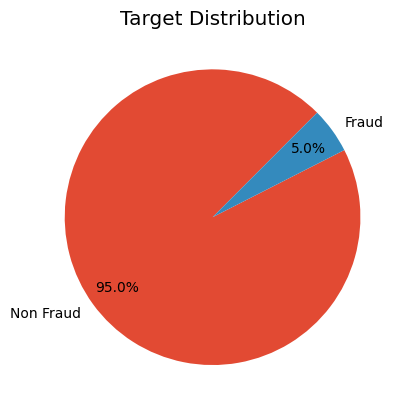

In [12]:
# visualizing the target feature relative frequency

target_counts = df['fraude'].value_counts()
plt.pie(
    target_counts.values,
    labels=('Non Fraud', 'Fraud'),
    autopct='%1.1f%%',
    pctdistance=0.8,
    startangle=45
)
plt.title('Target Distribution')
plt.show()

As we may notice, the dataset is **highly imbalanced** with only 5% of the samples being fraudulent purchases.

Now let's visualize the numeric features distributions with **histograms** and **boxplots**.

In [13]:
def plot_numeric(df, feature, bins=10):
    """
        Plot a histogram and a boxplot of a numeric feature distribution.
    """
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[feature], bins=bins, ax=ax0)
    sns.boxplot(df[feature], ax=ax1)
    fig.suptitle('{} Distribution'.format(feature))
    fig.show()

### score_2

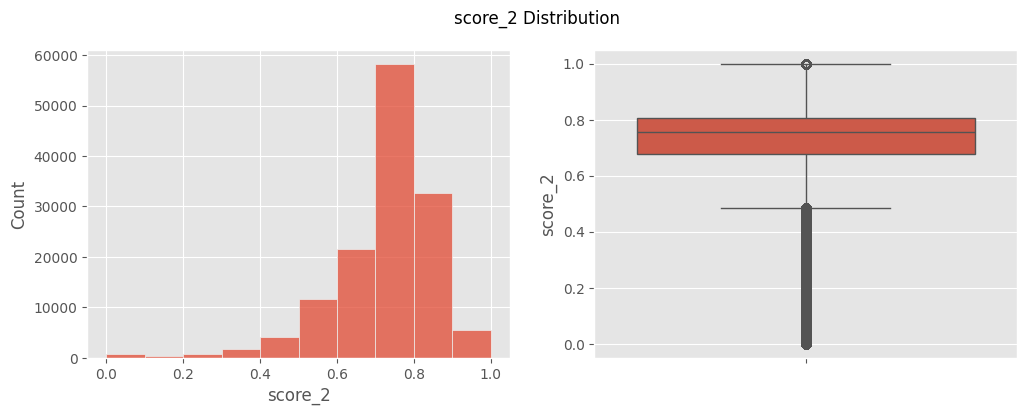

In [14]:
# visualizing score_2 distribution
plot_numeric(df, 'score_2')

In [15]:
# showing score_2 statistical measures
df['score_2'].describe()

count    137016.000000
mean          0.728115
std           0.132943
min           0.000000
25%           0.678400
50%           0.755500
75%           0.806500
max           1.000000
Name: score_2, dtype: float64

The _score_2_ variable is continuous and has a negative skewed distribution, with values ranging between 0 and 1 and median equals to 0,755. The median and the 3º quartile(0.806) are close to each other, indicating the high concentration of sample values between both measures. Also, there are some extreme values below 0,49, indicating the presence of **outliers**.

### score_3

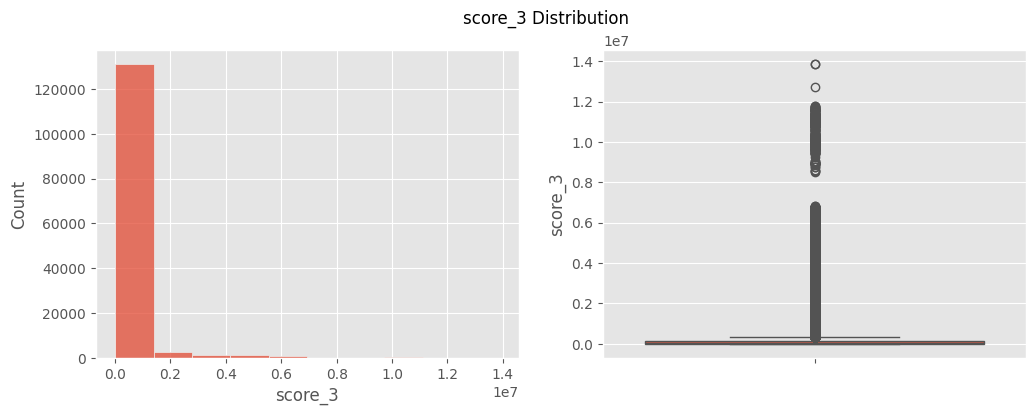

In [16]:
# visualizing score_3 distribution
plot_numeric(df, 'score_3')

In [17]:
# showing score_3 statistical measures
df['score_3'].describe()

count    1.370160e+05
mean     2.604451e+05
std      8.464361e+05
min      1.600000e-01
25%      9.679915e+03
50%      4.371165e+04
75%      1.454436e+05
max      1.387874e+07
Name: score_3, dtype: float64

The _score_3_ variable is continuous and has a positive skewed distribution, with values ranging between 0,16 and 1,4e^7. Almost 80% of the sample values are below 150000, and there are a lot of **outliers** present in its distribution.

### score_4

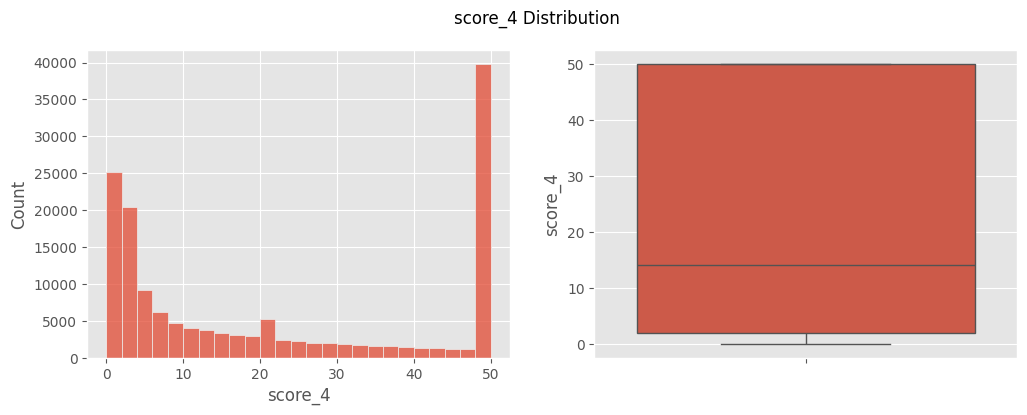

In [18]:
# visualizing score_4 distribution
plot_numeric(df, 'score_4', bins=25)

In [19]:
# showing score_4 statistical measures
df['score_4'].describe()

count    149635.000000
mean         21.677669
std          20.062146
min           0.000000
25%           2.000000
50%          14.000000
75%          50.000000
max          50.000000
Name: score_4, dtype: float64

The _score_4_ variable is continuous, with values ranging between 0 and 50. This variable has an interesting distribution. There are two regions with high concentration of values, being 50% of the values between 0 and 14 and more than 25% equals to 50.

### score_5

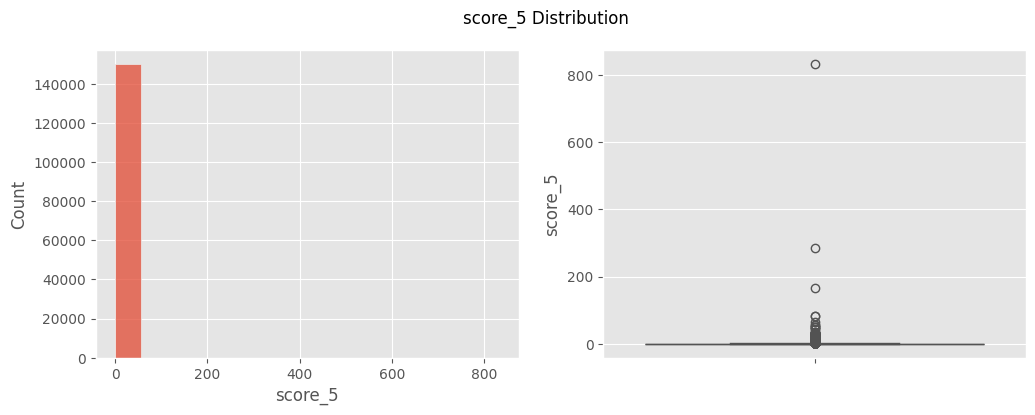

In [20]:
# visualizing score_5 distribution
plot_numeric(df, 'score_5', bins=15)

In [21]:
# showing score_5 statistical measures
df['score_5'].describe()

count    150000.000000
mean          0.220641
std           2.434995
min           0.000000
25%           0.000000
50%           0.104875
75%           0.282938
max         833.333333
Name: score_5, dtype: float64

The _score_5_ variable is continuous with values ranging between 0 and 833,3. Its distribution has a high positive skewness, being most of its values less than 0,3. Also, there are a lot of zero values. These cases can be an indication that the respective credit bureau don't have information about the corresponding customer, or other reasons.

### score_6

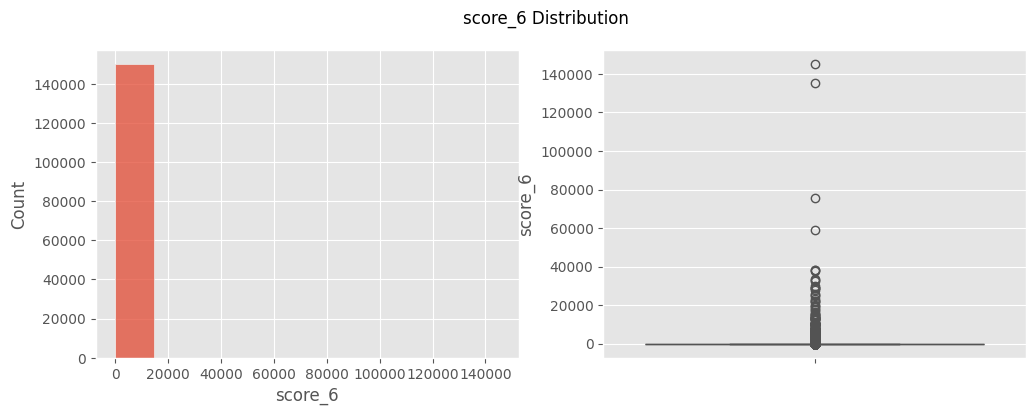

In [22]:
# visualizing score_6 distribution
plot_numeric(df, 'score_6')

In [23]:
# showing score_6 statistical measures
df['score_6'].describe()

count    149989.000000
mean         51.169352
std         709.472904
min          -5.000000
25%           1.000000
50%           8.000000
75%          33.000000
max      145274.000000
Name: score_6, dtype: float64

The _score_6_ variable is continuous and its values ranges between -5 and 146000. Its distribution is positively skewed and most of its values are below 33 and there are some extreme values indicating the presence of **outliers**.

### score_7

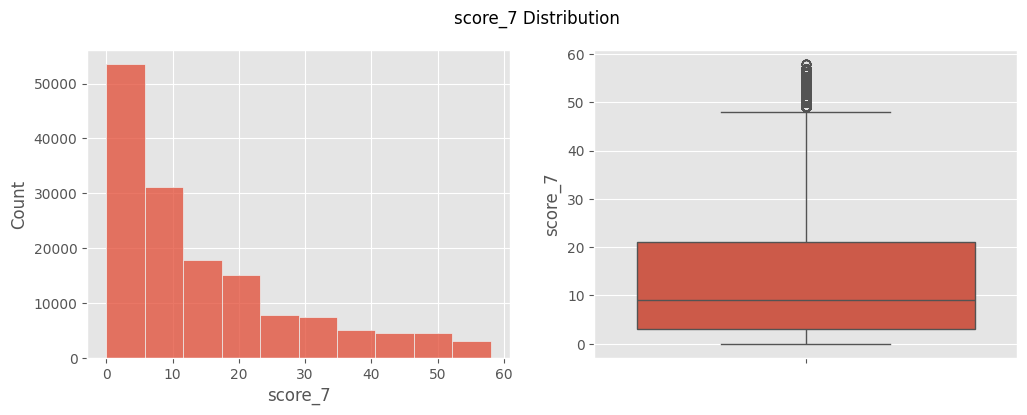

In [24]:
# visualizing score_7 distribution
plot_numeric(df, 'score_7')

In [25]:
# showing score_7 statistical measures
df['score_7'].describe()

count    150000.000000
mean         14.193513
std          14.161216
min           0.000000
25%           3.000000
50%           9.000000
75%          21.000000
max          58.000000
Name: score_7, dtype: float64

The _score_7_ variable is continuous and has a positive skewed distribution with values ranging between 0 and 58. Most values are below 21 and there are some extreme values above 48.

### score_8

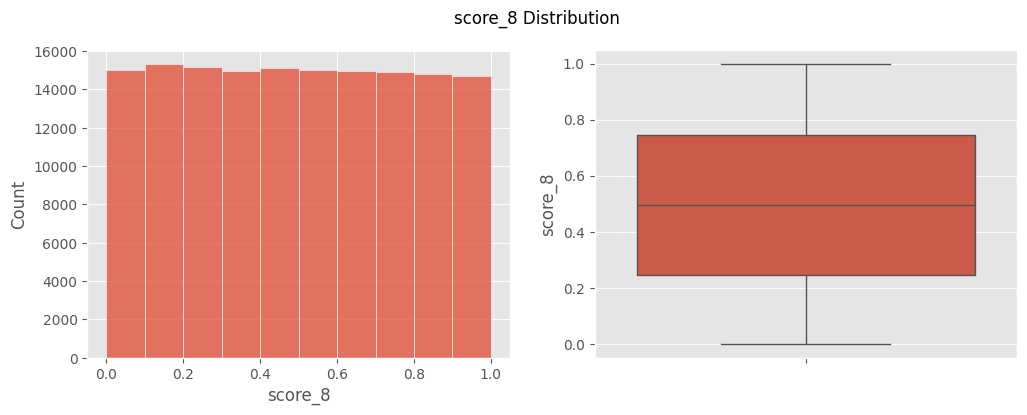

In [26]:
# visualizing score_8 distribution
plot_numeric(df, 'score_8')

In [27]:
# showing score_8 statistical measures
df['score_8'].describe()

count    150000.000000
mean          0.497532
std           0.288348
min           0.000004
25%           0.246819
50%           0.495990
75%           0.746508
max           0.999995
Name: score_8, dtype: float64

The _score_8_ variable is continuous and have a uniform distribution. Its values ranges between 0 and 1 and there aren't extreme values.

### score_9

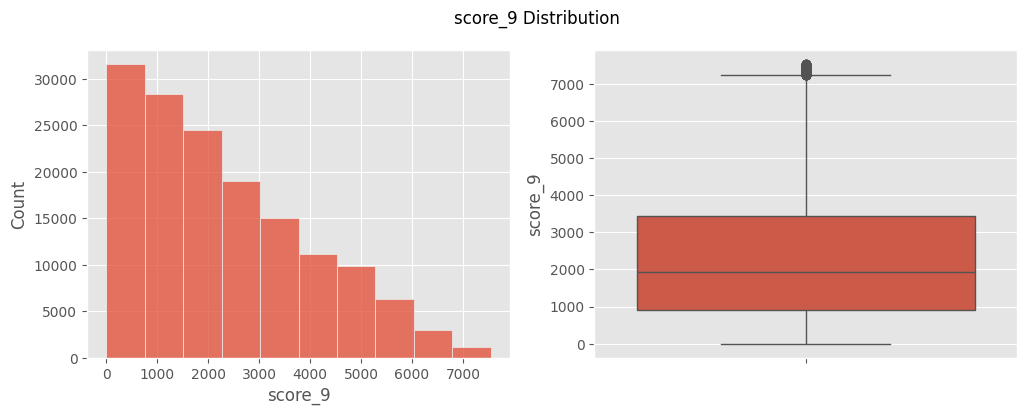

In [28]:
# visualizing score_9 distribution
plot_numeric(df, 'score_9')

In [29]:
# showing score_9 statistical measures
df['score_9'].describe()

count    149989.000000
mean       2305.409403
std        1712.379601
min           0.000000
25%         910.000000
50%        1937.000000
75%        3445.000000
max        7544.000000
Name: score_9, dtype: float64

The _score_9_ variable is continuous and has a positive skewed distribution. It's values ranges between 0 and 7544, with most values below 3500. Also, there are some extreme values above 7000, indicating the presence of outliers.

### score_10

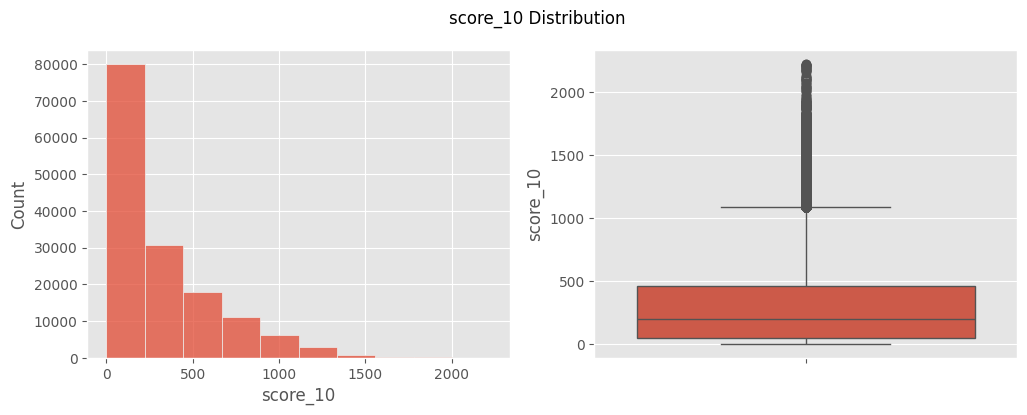

In [30]:
# visualizing score_10 distribution
plot_numeric(df, 'score_10')

In [31]:
# showing score_10 statistical measures
df['score_10'].describe()

count    149635.000000
mean        299.969579
std         321.075806
min           0.000000
25%          42.000000
50%         193.000000
75%         459.000000
max        2225.000000
Name: score_10, dtype: float64

The _score_10_ variable is continuous with a positive skewed distribution. Its values ranges between 0 and 2225, being most of them less than 460. There are extreme values, indicating the presence of outliers.

### valor_compra

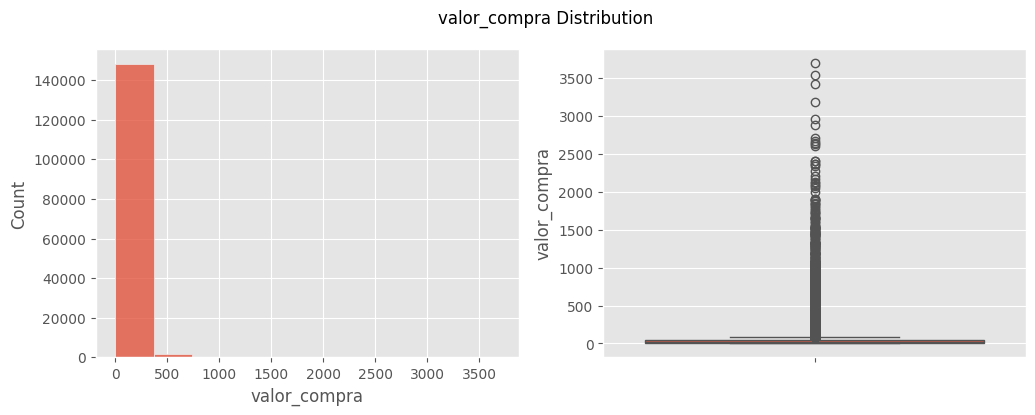

In [32]:
# visualizing valor_compra distribution
plot_numeric(df, 'valor_compra')

In [33]:
# showing valor_compra statistical measures
df['valor_compra'].describe()

count    150000.000000
mean         43.523134
std          91.557888
min           0.020000
25%           9.380000
50%          20.610000
75%          40.692500
max        3696.350000
Name: valor_compra, dtype: float64

The _valor_compra_ variable is continuous and its distribution is highly positive skewed. Its values ranges between 0,02 and 3700,00. It represents the price of the purchased products and as we can observe, most purchases have low prices, most of them are between 9 and 40. We have some extreme values, purchases of expensive products.

From the analysis above, we saw that almost all the numeric features have skewed distributions, with the exception of _score_4_ and _score_8_. Some of them contains an expressive amount of **outliers**. Considering the high quantity of **outliers**, we will have to choose machine learning models that are robust to them.

Now that we have a better understanding about the numeric features, let's dive into the categorical features.

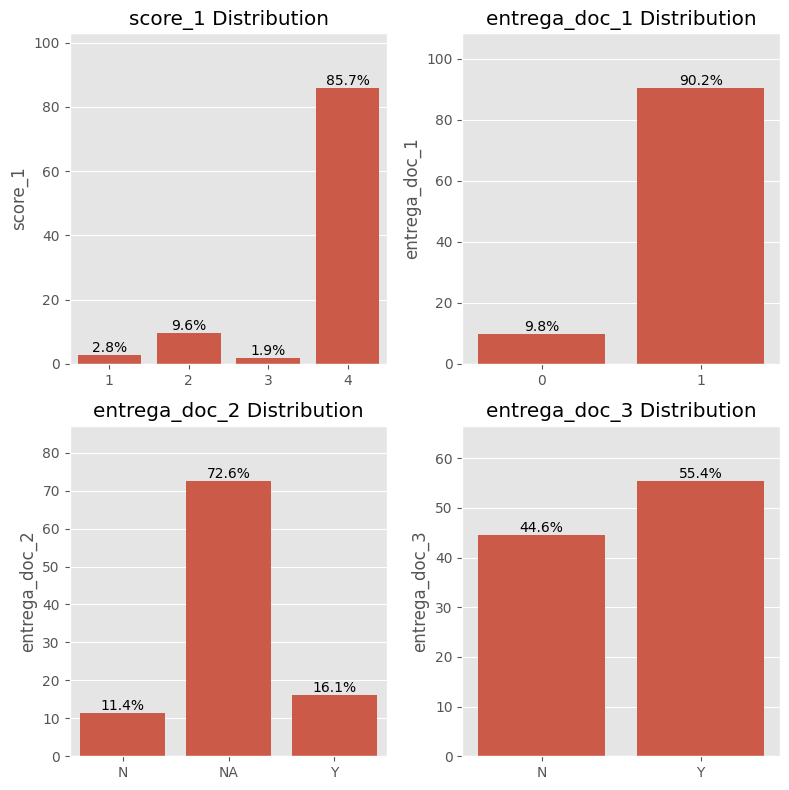

In [34]:
categorical = ['score_1', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']
n_cols = 2
n_rows = math.ceil(len(categorical) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.ravel()

for i, feature in enumerate(categorical):
    ax = axes[i]
    val_counts = df[feature].fillna('NA').value_counts(sort=True, ascending=False, normalize=True).sort_index() * 100
    sns.barplot(x=val_counts.index, y=val_counts, ax=ax)
    ax.set_title('{} Distribution'.format(feature))
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')
    ax.margins(y=0.2)
    ax.set_xlabel(None)

for ax in axes.flat[len(categorical):]:
    ax.remove()

plt.tight_layout()
plt.show()

The insights we got from the visualizations above are:
- More than 85% of the samples belongs to the class 4 of _score_1_.
- More than 90% of the customers delivered the document from _entrega_doc_1_.
- Most values of _entrega_doc_2_ are missing values and the distribution of non-missing values is balanced.
- _entrega_doc_3_ has a balanced distribution (55% of customers delivered the respective document).

Now we will evaluate the categorical features with high cardinality: **pais**, **produto** and **categoria_produto**. Considering the high quantity of unique values (classes) of these features, it would be too hard to visualize their distributions with graphs. Instead, we will make use of frequency tables to understand their values and distributions and get some insights.

In [35]:
def frequency_table(values, ascending=False, dropna=True):
    """
        Returns a frequency table for the values from values parameter.
    """
    table = values.value_counts(ascending=ascending, dropna=dropna).reset_index(name='absfreq')
    table['relfreq'] = table['absfreq'] / len(values)
    table['cumfreq'] = table['relfreq'].cumsum()
    return table

### pais

In [36]:
# display the first 10 rows of the frequency table of pais
frequency_table(df['pais']).head(10)

,index,absfreq,relfreq,cumfreq
0,BR,111628,0.744187,0.744187
1,AR,31964,0.213093,0.957280
2,UY,2967,0.019780,0.977060
3,US,2273,0.015153,0.992213
4,SE,358,0.002387,0.994600
5,MX,236,0.001573,0.996173
6,RU,73,0.000487,0.996660
7,ES,69,0.000460,0.997120
8,CO,64,0.000427,0.997547
9,GB,43,0.000287,0.997833


As expected, **Brazil** is the country with most transactions, followed by **Argentina**. These two countries represents more than **95%** of the transactions in the dataset.

### produto

In [37]:
def preprocess_products(df, filter_tokens=[]):
    """
        Preprocess products names to remove numbers, special characters and stop words.
    """
    batch_size = 1000
    processed_text = ''
    for i in range(0, len(df), batch_size):
        products = ' '.join(df.iloc[i:i+batch_size]['produto'])
        doc = nlp(products)
        filtered = [token for token in doc if token.is_alpha and not token.is_stop]
        filtered = [token for token in filtered if token.text not in filter_tokens]
        processed_text += ' ' + ' '.join(map(lambda x: x.text, filtered))
    return processed_text.strip()

In [38]:
# render a word cloud with the most common words in product names
# products = preprocess_products(df, filter_tokens=['cm', 'm', 'mm', 'Y', 'C', 'g', 'gb', 'kg', 'Cm', 'Gb', 'Mm'])
# wc = WordCloud(width=1000, height=860).generate(products)
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()

### categoria_produto

In [39]:
# display the first 5 rows of the frequency table of categoria_produto
cat_prod_ft = frequency_table(df['categoria_produto'])
cat_prod_ft.head()

,index,absfreq,relfreq,cumfreq
0,cat_43b9c10,2331,0.015540,0.015540
1,cat_d69bed9,1799,0.011993,0.027533
2,cat_604df77,1784,0.011893,0.039427
3,cat_6c4cfdc,1449,0.009660,0.049087
4,cat_4249bd8,1191,0.007940,0.057027


In [40]:
# checking the top N product categories that represents 80% of the transactions
cat_prod_ft[cat_prod_ft['cumfreq'] <= 0.8].tail()

,index,absfreq,relfreq,cumfreq
1445,cat_fc8b046,19,0.000127,0.799487
1446,cat_b0857ed,19,0.000127,0.799613
1447,cat_77f7849,19,0.000127,0.799740
1448,cat_a8d092c,19,0.000127,0.799867
1449,cat_d6ac515,19,0.000127,0.799993


There is not a predominant product category in the dataset, but 80% of the transactions were from 1450 of the 8324 product categories. This means that we have 1450 most frequent categories and the remaining may include less information and an excessive amount of variance for this variable. In the modeling phase we may consider grouping the low frequency categories into a single "rare" category.

## Multivariate Feature Analysis

Now that we completed the univariate analysis, we will analyze the relationship between two or more variables. To do this in a smart way, we will look for relationships between the independent variables with the target.

Before proceding, let's check if there is multicollinearity in the data. Multicollinearity happens when the independent variables are correlated between them. This can negatively impact coefficients estimation, being very bad when using linear statistical models.

### Checking Multicolinearity

Here we will try to detect multicolinearity by calculating the Pearson Correlation Coefficient. The correlation coefficient measures the linear relationship between two variables and its values ranges between -1 and 1. The closer to -1 or 1, the stronger is the relationship. Negative values indicates a negative relationship, and positive values indicates a positive relationship.

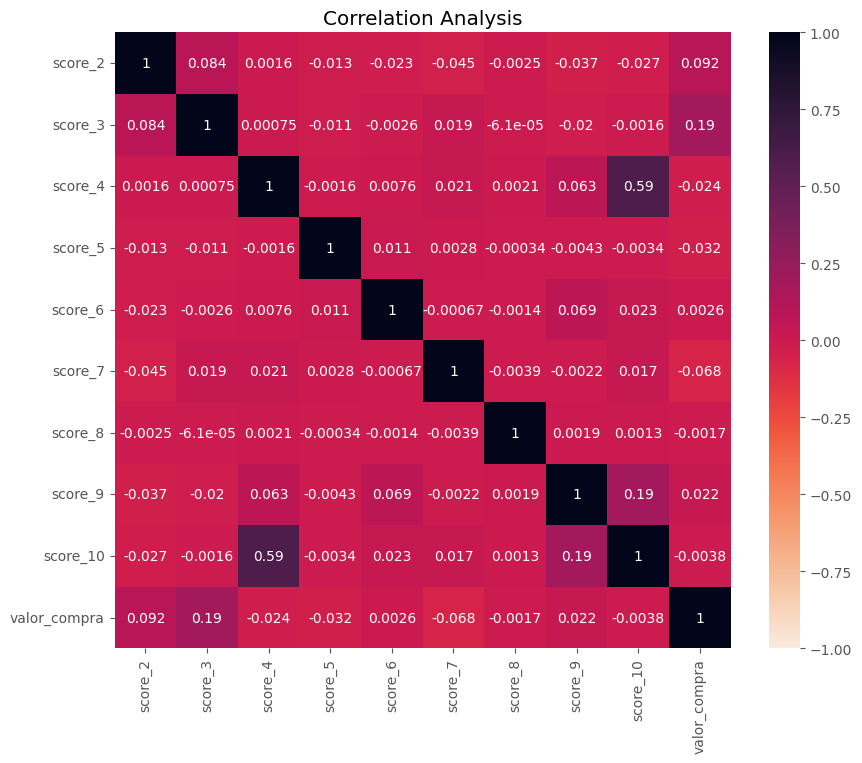

In [41]:
numeric = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra']
corr = df[numeric].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, square=True, vmin=-1, vmax=1, cmap='rocket_r')
plt.title('Correlation Analysis')
plt.show()

Luckly we don't have pair of independent variables with a very strong linear correlation, being the correlation between _score_4_ and _score_10_ the strongest, but not enough to cause problems in the future, so we will keep them.

### Relationship Between Numeric Features and the Target

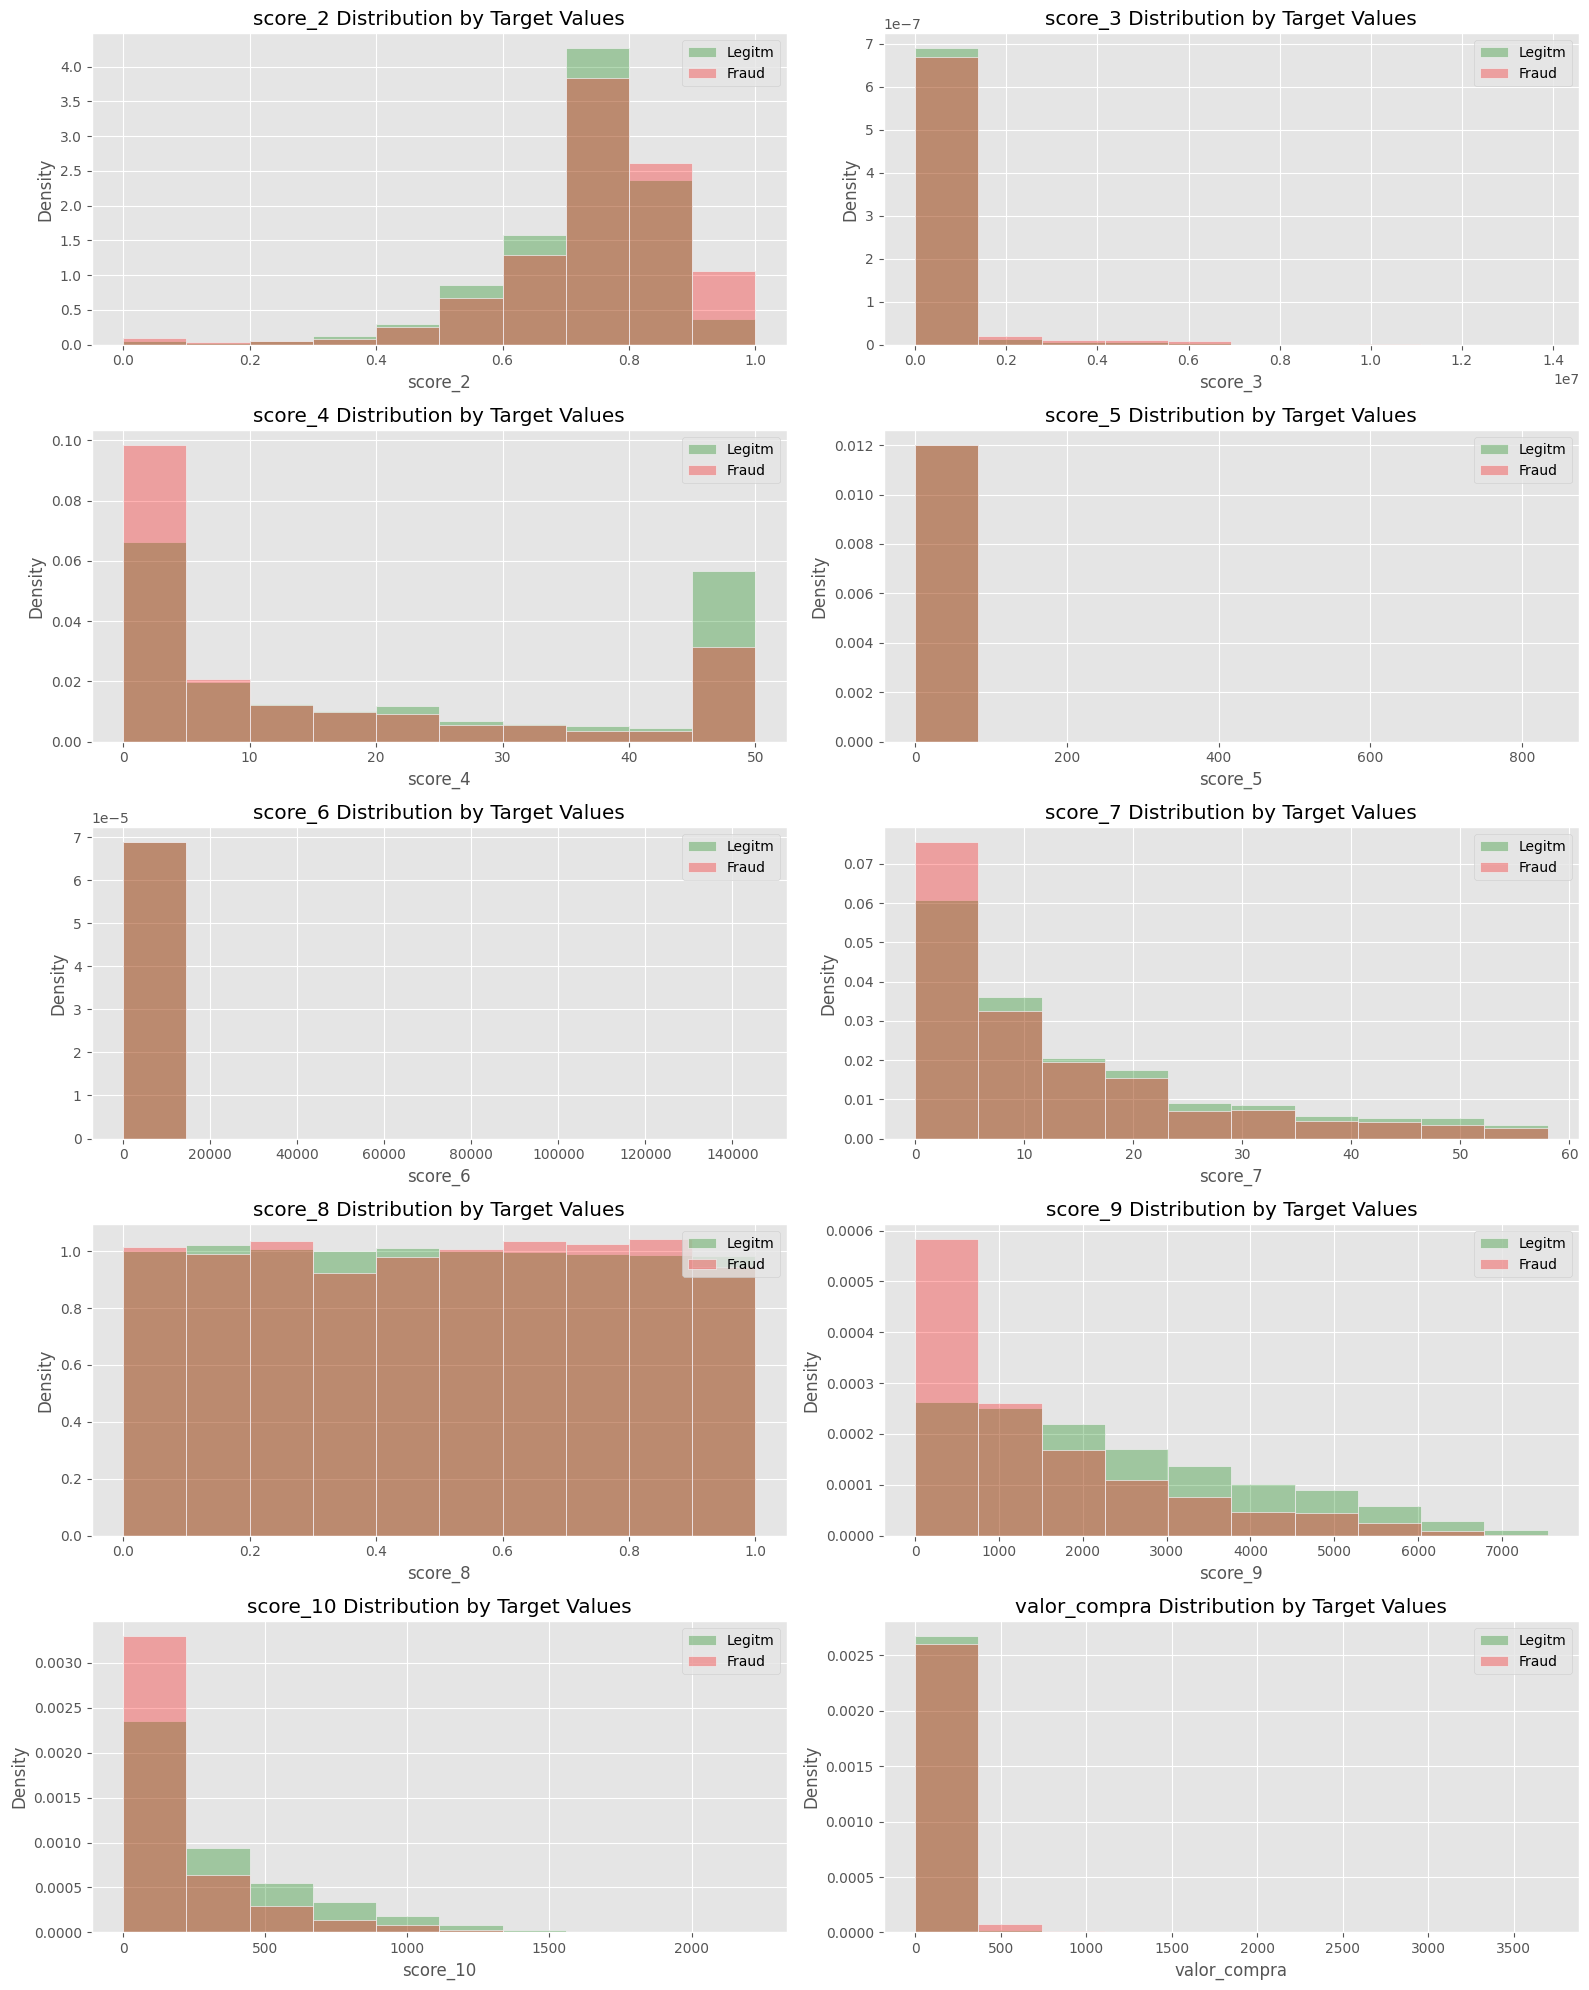

In [42]:
n_cols = 2
n_rows = math.ceil(len(numeric) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*4))
axes = axes.ravel()

for i, feature in enumerate(numeric):
    ax = axes[i]
    target_0 = df.loc[df['fraude'] == 0, feature]
    target_1 = df.loc[df['fraude'] == 1, feature]
    binrange = (min(target_0.min(), target_1.min()), max(target_0.max(), target_1.max()))
    sns.histplot(target_0, bins=10, binrange=binrange, stat='density', color='green', alpha=.3, label='Legitm', ax=ax)
    sns.histplot(target_1, bins=10, binrange=binrange, stat='density', color='red', alpha=.3, label='Fraud', ax=ax)
    ax.set_title('{} Distribution by Target Values'.format(feature))
    ax.legend()

fig.tight_layout()
fig.show()

Above we separated the dataset into samples from non-fraud from fraud transactions and plot their distributions together searching for relevant differences in their distributions. Even though all the distributions are similar, only _score_8_ seems to have the exact same distribution for both fraud and non-fraud transactions. To be more precise in our analysis, let's perform statistical tests to test these hypothesis.

### The Mann-Whitney U Test

"The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions." For more information, visit [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html).

This test adopts the equality between the distributions of the two independent samples as the null hypothesis, and the opposite as the alternative hypothesis. So, for **p-values** below 0,05 we will reject the null hypothesis and consider the distributions statistically different.

In [43]:
# performing the Mann-Whitney U Test between fraud and non-fraud transactions for all numeric variables

for feature in numeric:
    _, p = mannwhitneyu(
        df[df['fraude'] == 0][feature],
        df[df['fraude'] == 1][feature],
        alternative='two-sided',
        nan_policy='omit'
    )
    
    if p >= 0.05:
        print('{}: p-value: {:.2f} - The distributions are the same.'.format(feature, p))
    else:
        print('{}: p-value: {:.2f} - The distributions are NOT the same.'.format(feature, p))

score_2: p-value: 0.00 - The distributions are NOT the same.
score_3: p-value: 0.00 - The distributions are NOT the same.
score_4: p-value: 0.00 - The distributions are NOT the same.
score_5: p-value: 0.00 - The distributions are NOT the same.
score_6: p-value: 0.00 - The distributions are NOT the same.
score_7: p-value: 0.00 - The distributions are NOT the same.
score_8: p-value: 0.35 - The distributions are the same.
score_9: p-value: 0.00 - The distributions are NOT the same.
score_10: p-value: 0.00 - The distributions are NOT the same.
valor_compra: p-value: 0.00 - The distributions are NOT the same.


The statistical test confirmed our hyphotesis and we won't consider _score_8_ as a good predictor variable to our models, since there are no significant association between it and the target.

### Relationship Between Categorical Features and the Target

In [44]:
non_fraud = df[df['fraude'] == 0]
fraud = df[df['fraude'] == 1]

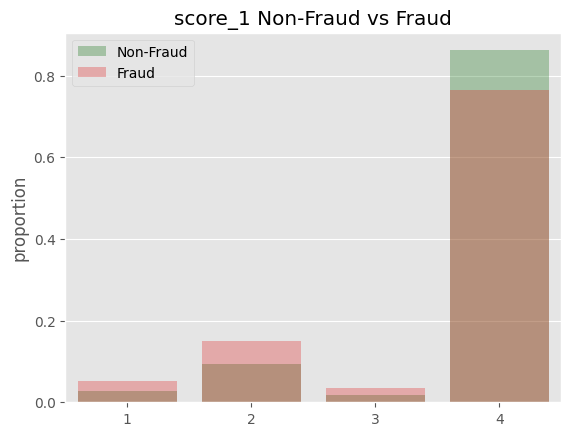

In [45]:
sns.countplot(non_fraud, x='score_1', stat='proportion', color='green', alpha=.3, label='Non-Fraud')
sns.countplot(fraud, x='score_1', stat='proportion', color='red', alpha=.3, label='Fraud')
plt.title('score_1 Non-Fraud vs Fraud')
plt.legend()
plt.xlabel(None)
plt.show()

It seems to exist an association between score_1 and the target in a way that samples from classes 1, 2 and 3 of score_1 tend to have a greater chance of being fraudulent.

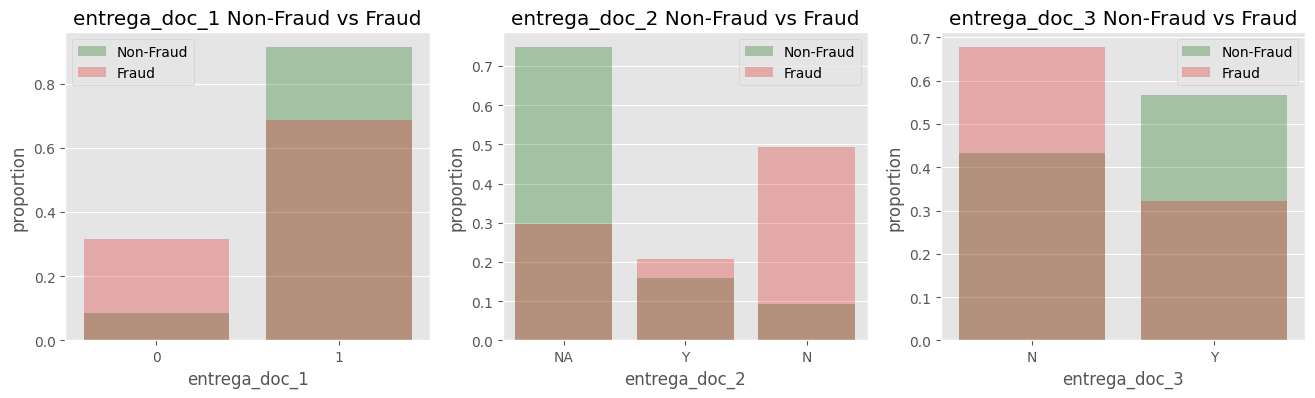

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, feature in enumerate(['entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']):
    sns.countplot(non_fraud.fillna('NA'), x=feature, stat='proportion', color='green', alpha=.3, label='Non-Fraud', ax=axes[i])
    sns.countplot(fraud.fillna('NA'), x=feature, stat='proportion', color='red', alpha=.3, label='Fraud', ax=axes[i])
    axes[i].set_title(f'{feature} Non-Fraud vs Fraud')

fig.show()

The proportion of fraudulent transactions are higher for customers that don't deliver the identity documents by the time of account creation.

Considering the high cardinality of the variables _pais_ and _produto_ and _categoria_produto_, it wouldn't be feasible to analyze their relationships with the target graphically. Instead, we will now test the association between all the categorical feature with the target with a statistical test.

### The Chi-square Test of Independence of Variables

The chi-squared test checks if there is a statistically significant relationship between two categorical features. In this test, the null hypothesis is that there isn't an association between the features, and the alternative hypothesis is the opposite. In our case, for **p-values** below 0.05 we will assume the feature have an association with the target.

In [47]:
def contingency_table(data, rows, columns, normalize=False, aggfunc='count'):
    """
        Return a contingency table between two variables.
    """
    contingency_table = pd.crosstab(
        data[rows],
        data[columns],
        values=data[columns],
        aggfunc=aggfunc,
        normalize=normalize
    )
    
    return contingency_table

In [48]:
categorical = ['score_1', 'pais', 'produto', 'categoria_produto', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']

for feature in categorical:
    res = chi2_contingency(contingency_table(df, rows=feature, columns='fraude').fillna(0))
    p = res.pvalue
    
    if p >= 0.05:
        print('{}: p-value: {:.2f} - There is NOT an association with the target.'.format(feature, p))
    else:
        print('{}: p-value: {:.2f} - There is an association with the target.'.format(feature, p))

score_1: p-value: 0.00 - There is an association with the target.
pais: p-value: 0.00 - There is an association with the target.
produto: p-value: 0.52 - There is NOT an association with the target.
categoria_produto: p-value: 0.00 - There is an association with the target.
entrega_doc_1: p-value: 0.00 - There is an association with the target.
entrega_doc_2: p-value: 0.00 - There is an association with the target.
entrega_doc_3: p-value: 0.00 - There is an association with the target.


### Temporal Analysis

In [49]:
df_time = df[['data_compra', 'fraude']].copy()

def extract_time_features(df, datetime):
    assert('datetime' in df[datetime].dtype.name)
    
    df['date'] = df[datetime].dt.date
    df['year'] = df[datetime].dt.year
    df['month'] = df[datetime].dt.month
    df['day'] = df[datetime].dt.day
    df['dayofweek'] = df[datetime].dt.dayofweek
    df['dayofyear'] = df[datetime].dt.dayofyear
    df['hour'] = df[datetime].dt.hour
    
    return df

df_time = extract_time_features(df_time, 'data_compra')
df_time.head()

,data_compra,fraude,date,year,month,day,dayofweek,dayofyear,hour
0,2020-03-27 11:51:16,0,2020-03-27,2020,3,27,4,87,11
1,2020-04-15 19:58:08,0,2020-04-15,2020,4,15,2,106,19
2,2020-03-25 18:13:38,0,2020-03-25,2020,3,25,2,85,18
3,2020-04-16 16:03:10,0,2020-04-16,2020,4,16,3,107,16
4,2020-04-02 10:24:45,0,2020-04-02,2020,4,2,3,93,10


In [50]:
df_time['year'].unique()

array([2020])

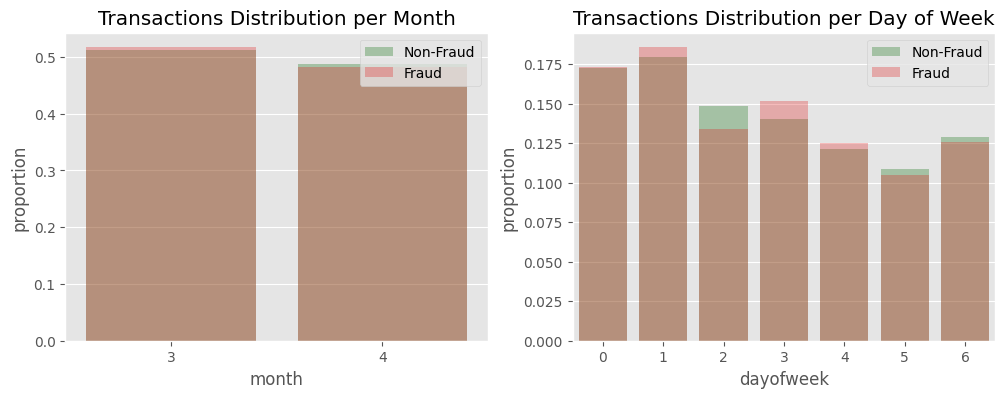

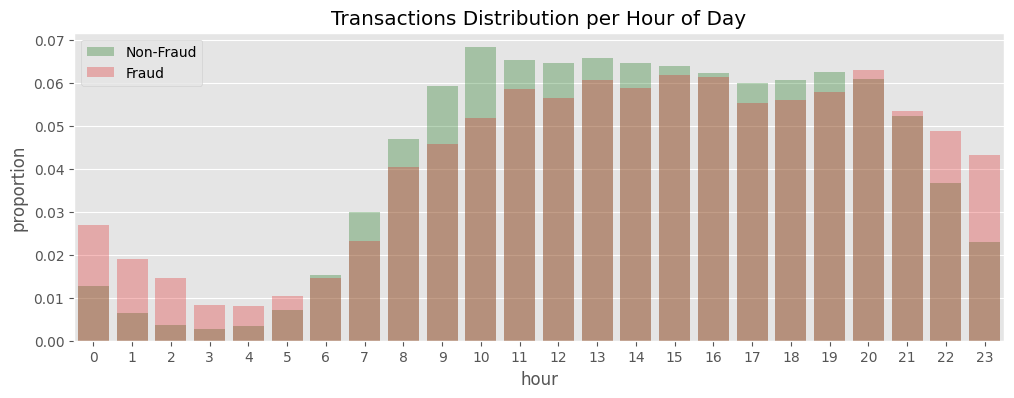

In [51]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(df_time[df_time['fraude'] == 0], x='month', stat='proportion', color='green', alpha=.3, label='Non-Fraud', ax=ax0)
sns.countplot(df_time[df_time['fraude'] == 1], x='month', stat='proportion', color='red', alpha=.3, label='Fraud', ax=ax0)
ax0.set_title('Transactions Distribution per Month')

sns.countplot(df_time[df_time['fraude'] == 0], x='dayofweek', stat='proportion', color='green', alpha=.3, label='Non-Fraud', ax=ax1)
sns.countplot(df_time[df_time['fraude'] == 1], x='dayofweek', stat='proportion', color='red', alpha=.3, label='Fraud', ax=ax1)
ax1.set_title('Transactions Distribution per Day of Week')

fig.show()

fig, ax = plt.subplots(figsize=(12, 4))

sns.countplot(df_time[df_time['fraude'] == 0], x='hour', stat='proportion', color='green', alpha=.3, label='Non-Fraud', ax=ax)
sns.countplot(df_time[df_time['fraude'] == 1], x='hour', stat='proportion', color='red', alpha=.3, label='Fraud', ax=ax)
ax.set_title('Transactions Distribution per Hour of Day')

fig.show()

The transactions in the dataset were made between Mar/2020 and Apr/2020 and the transaction amount is balanced between the two months. Also, there are transactions in every day of the week and every hour of the day, indicating that the e-commerce works 24/7. 

Most of the transactions were made on Mondays and Tuesdays from 8am until 8pm and the month and day of week don't seem to be related to higher fraud occurences, but we can observe a higher proportion of frauds from 11pm until 5am.

**Conclusions:**
- All numeric features, but _score_8_ and _score_4_, have skewed distributions.
- Almost all the features seems to be related with the target variable, with exception of _score_8_ and _produto_.
- Customers that don't delivered some documents by the time of account creation have higher chance of making fraudulent transactions.
- The proportion of fraudulent transactions is higher at dawn.

Now that we got a sense about the data, it's time to prepare the data for machine learning.

## Preparing Data for Machine Learning

<div style="display: block; text-align: center;">
    <img style="width: 400px" src="img/prepare.png" alt="Data Exploration"/>
</div>

In [80]:
TARGET = 'fraude'

# restore original df
df = df_original.copy()

df.drop(['produto', 'score_fraude_modelo', 'data_compra'], axis=1, inplace=True)

### Creating New Features

In [81]:
def create_features(df):
    for feature in df.columns:
        missing = df[feature].isnull()
        
        if missing.sum() > 0:
            df['is_missing_{}'.format(feature)] = missing.astype(int)
            
    num_features = [f'score_{i}' for i in range(2, 11)] + ['valor_compra']
    for feature in num_features:
        df[f'{feature}_log'] = np.log(df[feature] + 1e-5)
        df[f'{feature}_sqrt'] = np.sqrt(df[feature])
        df[f'{feature}_sin'] = np.sin(df[feature])
        
    df['entrega_doc_count'] = df.apply(lambda x: sum((
        int(x['entrega_doc_1'] == 1),
        int(x['entrega_doc_2'] == 'Y'),
        int(x['entrega_doc_3'] == 'Y')
    )), axis=1)
    
    return df

# adding new features to the dataset
df = create_features(df)

### Splitting Data Into Train and Test

The objective of machine learning modeling is to build a model capable of make accurate predictions on data that wasn't used for training. In order to be able to estimate model performance and generalization capacity in the real world scenario, we need to split the dataset into train and test datasets.

The test dataset remains untouched until the end of the modeling phase, and it will only be used to get the final estimates about the obtained models performances. In this project we will use **80%** of the data for modeling and **20%** for testing.

In [82]:
df_train, df_test = train_test_split(df, shuffle=True, stratify=df[TARGET], test_size=0.2, random_state=SEED)

In [83]:
class KFoldTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits=5, stratify=False, shuffle=True, random_state=None):
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        self.stratify = stratify
        self.cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)\
            if not stratify else StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        
    def fit(self, X, y, **fit_params):
        self.means = {}
        self.features = X.columns.to_list()
        X_y = pd.concat((X, y), axis=1)
        self.encoded = pd.DataFrame(data=np.zeros(X.shape, dtype=np.float64), columns=self.features, index=X.index)
        
        for i, feature in enumerate(self.features):
            for train_index, test_index in self.cv.split(X, y):
                target_means = X_y.iloc[train_index].groupby(feature)[y.name].mean()
                self.encoded.iloc[test_index,i] = X_y.iloc[test_index,i].map(target_means).fillna(0.0).astype('float')
        
        merged = X.merge(self.encoded, how='left', left_index=True, right_index=True, suffixes=(None, '_encoded'))
        self.mappings = {}
        for feature in self.features:
            self.mappings[feature] = merged.groupby(feature)['{}_encoded'.format(feature)].mean()
            
        return self
    
    def transform(self, X):
        assert len(list(set(X.columns) - set(self.features))) == 0
        
        for feature in self.features:
            mapping = self.mappings[feature].to_dict()
            uniques = X[feature].unique()
            unknown = list(set(uniques) - set(mapping.keys()))
            
            for u in unknown:
                mapping[u] = 0.0
            
            X[feature] = X[feature].map(mapping).fillna(0.0).astype('float')
            
        return X
    
    def fit_transform(self, X, y, **fit_params):
        self.fit(X, y)
        X.loc[:,self.features] = self.encoded
        X[self.features] = X[self.features].astype('float')
        return X

In [84]:
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.to_list()
categorical_features = list(set(X_train.columns) - set(numeric_features))

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('pais_rare_label', RareLabelEncoder(variables=['pais'], max_n_categories=3)),
    ('categoria_produto_rare_label', RareLabelEncoder(tol=0.0001, variables=['categoria_produto'], max_n_categories=1449)),
    ('encoder', KFoldTargetEncoder(stratify=True, random_state=SEED))
])

preprocessor = ColumnTransformer(transformers=[
    ('categorical_transformer', categorical_transformer, categorical_features),
    ('numeric_transformer', numeric_transformer, numeric_features)
], verbose_feature_names_out=False, remainder='passthrough')

In [85]:
X_train_pre = preprocessor.fit_transform(X_train, y_train)
X_test_pre = preprocessor.transform(X_test)

In [86]:
X_train_pre.head()

,pais,entrega_doc_2,categoria_produto,entrega_doc_3,score_1,score_2,score_3,score_4,score_7,score_9,...,score_7_sin,score_9_log,score_9_sqrt,score_9_sin,score_10_log,score_10_sqrt,score_10_sin,valor_compra_log,valor_compra_sqrt,entrega_doc_count
40222,0.055218,0.028501,0.000000,0.076368,4.0,0.7554,43648.59,1.0,19.0,3122.0,...,0.149877,8.046229,55.874860,-0.676572,5.198497,13.453624,-0.936451,3.713328,6.402343,1.0
113835,0.055227,0.028237,0.070093,0.028608,4.0,0.8218,31927.51,20.0,0.0,5573.0,...,0.000000,8.625689,74.652528,-0.184308,6.966967,32.572995,-0.756743,2.204973,3.011644,3.0
67288,0.055275,0.028514,0.050536,0.028584,4.0,0.6871,11216.54,24.0,10.0,3136.0,...,-0.544021,8.050703,56.000000,0.636947,5.308268,14.212670,0.806418,3.173042,4.886717,2.0
118571,0.055218,0.028501,0.091716,0.076368,4.0,0.7930,31825.54,4.0,5.0,61.0,...,-0.958924,4.110874,7.810250,-0.966118,4.043051,7.549834,0.436165,3.440098,5.584801,0.0
5463,0.023343,0.218026,0.133333,0.076671,4.0,0.4413,22360.01,8.0,30.0,3574.0,...,-0.988032,8.181441,59.782941,-0.905450,2.995733,4.472136,0.912945,2.965789,4.405678,0.0


### Feature Selection

In [87]:
def information_value(X, y, bins=5):
    N = len(y)
    Good = np.sum(y)
    Bad = N - Good
    
    unique = X.unique()
    if X.dtype != 'object' and len(unique) > bins:
        X = pd.cut(X, bins=bins, retbins=False)
        
    iv_table = pd.crosstab(X, y, y, aggfunc='count', normalize='columns')
    iv_table['woe'] = iv_table.apply(lambda x: np.log(x[0] / (x[1] + 1e-6)) if x[0] > 0 and x[1] > 0 else 0.0, axis=1)
    iv_table['iv'] = (iv_table[0] - iv_table[1]) * iv_table['woe']
    return np.sum(iv_table['iv'])

features = X_train_pre.columns.to_list()
features_iv = np.round(pd.Series(data=[information_value(X_train_pre[feature], y_train) for feature in features], index=features), 2)
features_iv.sort_values(ascending=False)

entrega_doc_2               0.90
is_missing_entrega_doc_2    0.87
entrega_doc_count           0.45
score_6_log                 0.42
score_9_sqrt                0.39
entrega_doc_1               0.36
score_9_log                 0.28
score_9                     0.28
score_10_log                0.27
score_10_sqrt               0.26
entrega_doc_3               0.25
categoria_produto           0.20
score_6_sin                 0.20
score_4_sqrt                0.16
score_10                    0.15
score_4                     0.14
score_4_log                 0.13
score_4_sin                 0.09
score_10_sin                0.08
score_3_log                 0.07
valor_compra_sqrt           0.07
score_1                     0.07
valor_compra_log            0.06
score_7_log                 0.06
pais                        0.05
score_2                     0.04
score_7_sqrt                0.04
score_7_sin                 0.03
score_5_log                 0.03
score_7                     0.02
score_9_si

In [88]:
selected_features = features_iv[features_iv >= 0.02].index.to_list()

In [89]:
X_train_fs = X_train_pre[selected_features]
X_test_fs = X_train_pre[selected_features]

## Model Selection

In [104]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
model_scores = {}

### Logistic Regression

In [105]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_fs)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=True)
scores = cross_val_score(lr, X_train_sc, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
model_scores['LR'] = scores
print('Logistic Regression ROC AUC: {:.4f}±{:.4f}'.format(np.mean(scores), np.std(scores)))

Logistic Regression ROC AUC: 0.8437±0.0047


### Decision Tree

In [106]:
dt = DecisionTreeClassifier(random_state=SEED)
scores = cross_val_score(dt, X_train_fs, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
model_scores['DT'] = scores
print('Decision Tree ROC AUC: {:.4f}±{:.4f}'.format(np.mean(scores), np.std(scores)))

Decision Tree ROC AUC: 0.6064±0.0074


### Random Forests

In [107]:
rf = RandomForestClassifier(class_weight='balanced', random_state=SEED)
scores = cross_val_score(rf, X_train_fs, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
model_scores['RF'] = scores
print('Random Forests ROC AUC: {:.4f}±{:.4f}'.format(np.mean(scores), np.std(scores)))

Random Forests ROC AUC: 0.8254±0.0051


### XGBoost

In [117]:
xgbclf = xgb.XGBClassifier(scale_pos_weight=(len(y_train) - np.sum(y_train)) / np.sum(y_train), random_state=SEED)
scores = cross_val_score(xgbclf, X_train_fs, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
model_scores['XGB'] = scores
print('XGBoost ROC AUC: {:.4f}±{:.4f}'.format(np.mean(scores), np.std(scores)))

XGBoost ROC AUC: 0.8134±0.0095


### LightGBM

In [109]:
lgbmclf = lgbm.LGBMClassifier(class_weight='balanced', random_state=SEED)
scores = cross_val_score(lgbmclf, X_train_fs, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
model_scores['LGBM'] = scores
print('LightGBM ROC AUC: {:.4f}±{:.4f}'.format(np.mean(scores), np.std(scores)))

LightGBM ROC AUC: 0.8481±0.0042


In [120]:
cb = CatBoostClassifier(class_weights=compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), random_state=SEED, verbose=0)
scores = cross_val_score(cb, X_train_fs, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)
model_scores['CB'] = scores
print('CatBoost ROC AUC: {:.4f}±{:.4f}'.format(np.mean(scores), np.std(scores)))

CatBoost ROC AUC: 0.8347±0.0052
